# 图片风格迁移

这篇教程是针对 ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) 这篇paper的编译，同学们有兴趣可以阅读原文，加深理解。

首先，我们导入需要的一堆库

In [5]:
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

## 第一步：读入图片

我们首先把我们的内容和风格两个图片都读进来。

（内容图片为免版权文件，风格图片为世界名作，版权所有归原作者所有，不得随意传播）

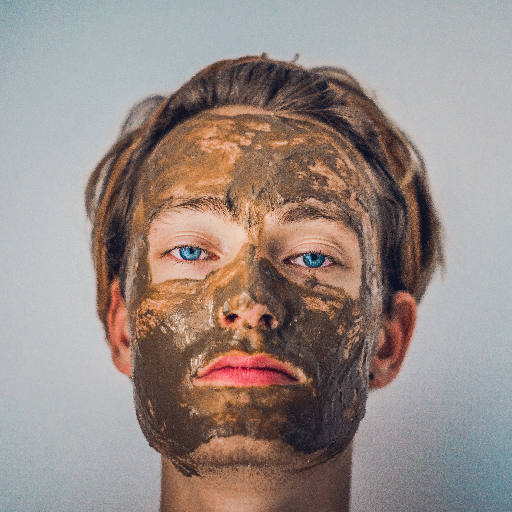

In [6]:
# 定义一下长宽
height = 512
width = 512

# 路径
content_image_path = 'images/isabell.jpg'
content_image = Image.open(content_image_path)
# 搞成统一大小，便于稍后的处理
content_image = content_image.resize((height, width))
content_image

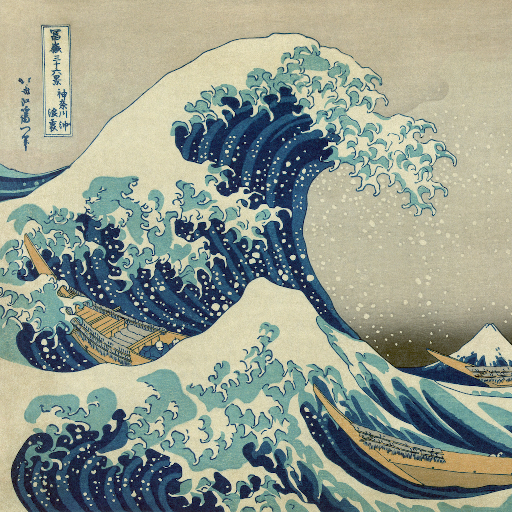

In [7]:
# 同理，读入风格图片

style_image_path = 'images/styles/wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

接下来，我们多加一层dimension给我们的图片数据，搞成4维，而不是普通的三维图片数据。

为了接下来把两个图片concat在一起的时候，更方便。

In [8]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


之前课上讲过，我们要站在巨人肩膀上做创新。

这个图片处理领域的巨人就是VGG-16，前人已经训练成熟并在ImageNet上发挥完美的一套CNN。[Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556)

为了使用这个巨人模型，我们需要把我们自己的数据拟合进VGG-16的格式中。

1. 保证色调色域的一致：VGG16是在ImageNet上跑出来的，我们也把我们的数据『平均化』到ImageNet的色域上，也就是，把我们的图片统一剪掉一个ImageNet的平均值，使得我们自己的图片色彩分布更符合ImageNet的原始图片库。[ImageNet training set](http://image-net.org) 
2. 保证色彩维度位置一致：VGG16里不是RGB而是BGR，我们把三个维度调换一下。

In [9]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

在使用Keras的backend之前，我们把合成照片的backend variable给搞好，应该是跟我们的原图一样大小

In [10]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

然后 我们把三个图片都concate在一起

In [11]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## 第二步：调用pretrain的VGG16完成我们的工作

课上讲过，VGG是在图片分类任务中被训练出来的，我们感兴趣的就是它把图片处理成『数字化的表达形式』的功能。

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

调用VGG16以后，它会自动下载fchollet的VGG16的weights

In [12]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

此刻，我们可以看一看整个神经网络的长相

In [13]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

# 优化

课上讲过，我们这里用三个损失方程来优化我们的图片：

*content loss*

*style loss*

*total variation loss*

我们给三个loss先附上权值

In [14]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

初始化：

全都设置为0

In [15]:
loss = backend.variable(0.)

### The content loss

接下来我们处理content loss

In [16]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### The style loss

以及style loss

先写出Gram Matrix的方法

In [17]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

然后再写出Style Loss的方法

In [18]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss

以及整体loss

In [19]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## 用Gradients解决Optimisation问题

一个是loss，一个是我们的合成图片

In [20]:
grads = backend.gradients(loss, combination_image)

细化准备一个我们的Evaluator的方法

记录下每次的loss和新的gradient值

In [21]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

我们用一种比较快的Quasi-Newton算法来寻找最优解 [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) 

给个10轮

In [22]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 7.40154e+10
Iteration 0 completed in 24s
Start of iteration 1
Current loss value: 4.49243e+10
Iteration 1 completed in 20s
Start of iteration 2
Current loss value: 3.2532e+10
Iteration 2 completed in 20s
Start of iteration 3
Current loss value: 2.89146e+10
Iteration 3 completed in 20s
Start of iteration 4
Current loss value: 2.73842e+10
Iteration 4 completed in 21s
Start of iteration 5
Current loss value: 2.65476e+10
Iteration 5 completed in 20s
Start of iteration 6
Current loss value: 2.60869e+10
Iteration 6 completed in 20s
Start of iteration 7
Current loss value: 2.58278e+10
Iteration 7 completed in 21s
Start of iteration 8
Current loss value: 2.56635e+10
Iteration 8 completed in 20s
Start of iteration 9
Current loss value: 2.55627e+10
Iteration 9 completed in 20s


然后，得到了我们最新的图像的数字表达形式，

我们用之前处理的方式，反过去，把数据变回成图片

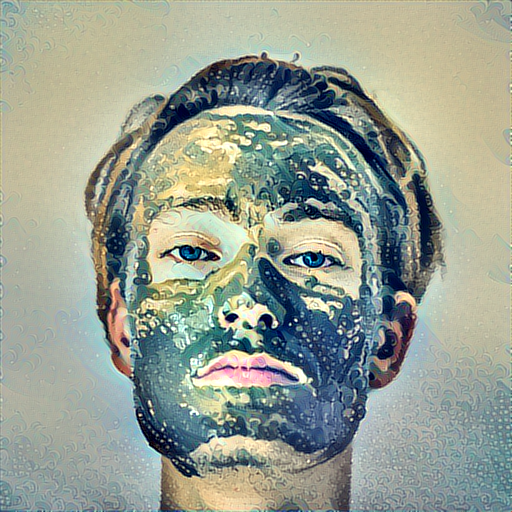

In [23]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

## 总结

这是一个非常直观的教程

同学们可以根据自己的喜好，简单调试各种参数，看看各种新奇的效果。